In [50]:
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd
import numpy as np
from models import KMeansPartitioner
from sklearn import preprocessing
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.models import hofts

from models import sthofts
import matplotlib.pyplot as plt

# Funções Auxiliares

In [51]:
def normalized_rmse(targets, forecasts):
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(forecasts, list):
        forecasts = np.array(forecasts)
    return ((np.sqrt(np.nanmean((targets - forecasts) ** 2))) / np.nanmean(targets) ) * 100

In [52]:
def normalize(df):
    mindf = df.min()
    maxdf = df.max()
    return (df-mindf)/(maxdf-mindf)

In [65]:
def denormalize(norm, _min, _max):
    return [(n * (_max-_min)) + _min for n in norm]

# Base de Dados
Montagem de casos de treinamento, validação e testes

In [54]:
df = pd.read_pickle("df_oahu.pkl")
df_ssa_clean = pd.read_pickle("df_ssa_clean.pkl")
df_ssa_residual = pd.read_pickle("df_ssa_residual.pkl")

In [72]:
interval = '2010-11'

sample_df = df.loc[interval]
residual_sample_df = df_ssa_residual.loc[interval]
clean_sample_df = df_ssa_clean.loc[interval]

norm_residual_sample_df = normalize(residual_sample_df)
norm_clean_sample_df = normalize(clean_sample_df)


week = (sample_df.index.day - 1) // 7 + 1

# PARA OS TESTES:
# 2 SEMANAS PARA TREINAMENTO
train_df = sample_df.loc[week <= 2]
train_residual_df = norm_residual_sample_df.loc[week <= 2]
train_clean_df = norm_clean_sample_df.loc[week <= 2]

# 1 SEMANA PARA VALIDACAO
validation_df = sample_df.loc[week == 3]
validation_residual_df = norm_residual_sample_df.loc[week == 3]
validation_clean_df = norm_clean_sample_df.loc[week == 3]

# 1 SEMANA PARA TESTES
test_df = sample_df.loc[week > 3]
test_residual_df = norm_sample_df.loc[week > 3]
test_clean_df = norm_clean_sample_df.loc[week > 3]




# Avaliação de Modelos

## 1 - Spatio-temporal High Order FTS 

In [369]:
def sthofts_forecast(_order, npartitions, col, train, validation):
    
    fuzzy_sets = KMeansPartitioner.KMeansPartitioner(data=train, npart=npartitions, batch_size=1000, init_size=npartitions*3)
    model_sthofts = sthofts.SpatioTemporalHighOrderFTS("FTS", nlags=_order, partitioner=fuzzy_sets)
    
    model_sthofts.fit(np.array(train.values), dump = 'time', num_batches=100)
    forecast_sthofts = model_hofts.predict(np.array(validation.values))
    forecast_hofts_df = pd.DataFrame(data=forecast_hofts, columns=validation.columns)
    return forecast_hofts_df[col].values

In [370]:
forecast = sthofts_forecast(_order, npartitions, col, train_df, validation_df)

[ 21:17:04] Start training
[ 21:17:04] Starting batch 1
[ 21:17:06] Finish batch 1
[ 21:17:06] Starting batch 2
[ 21:17:08] Finish batch 2
[ 21:17:08] Starting batch 3
[ 21:17:13] Finish batch 3
[ 21:17:13] Starting batch 4
[ 21:17:15] Finish batch 4
[ 21:17:15] Starting batch 5
[ 21:17:17] Finish batch 5
[ 21:17:17] Starting batch 6
[ 21:17:19] Finish batch 6
[ 21:17:19] Starting batch 7
[ 21:17:21] Finish batch 7
[ 21:17:21] Starting batch 8
[ 21:17:22] Finish batch 8
[ 21:17:22] Starting batch 9
[ 21:17:24] Finish batch 9
[ 21:17:24] Starting batch 10
[ 21:17:26] Finish batch 10
[ 21:17:26] Starting batch 11
[ 21:17:30] Finish batch 11
[ 21:17:30] Starting batch 12
[ 21:17:32] Finish batch 12
[ 21:17:32] Starting batch 13
[ 21:17:35] Finish batch 13
[ 21:17:35] Starting batch 14
[ 21:17:36] Finish batch 14
[ 21:17:36] Starting batch 15
[ 21:17:38] Finish batch 15
[ 21:17:38] Starting batch 16
[ 21:17:40] Finish batch 16
[ 21:17:40] Starting batch 17
[ 21:17:41] Finish batch 17
[ 21:

In [ ]:
norm_residual_forecast = sthofts_forecast(_order, npartitions, col, train_residual_df, validation_residual_df)
norm_clean_forecast = sthofts_forecast(_order, npartitions, col, train_clean_df, validation_clean_df)

residual_forecast = denormalize(norm_residual_forecast, residual_sample_df[col].min(), residual_sample_df[col].max())
clean_forecast = denormalize(norm_clean_forecast, clean_sample_df[col].min(), clean_sample_df[col].max())

forecast = [r + c for r, c in zip(residual_forecast,clean_forecast)]

[ 21:30:43] Start training
[ 21:30:43] Starting batch 1
[ 21:30:45] Finish batch 1
[ 21:30:45] Starting batch 2
[ 21:30:47] Finish batch 2
[ 21:30:47] Starting batch 3
[ 21:32:31] Finish batch 3
[ 21:32:31] Starting batch 4
[ 21:36:53] Finish batch 4
[ 21:36:53] Starting batch 5
[ 21:43:21] Finish batch 5
[ 21:43:21] Starting batch 6
[ 21:43:39] Finish batch 6
[ 21:43:39] Starting batch 7
[ 21:43:41] Finish batch 7
[ 21:43:41] Starting batch 8
[ 21:43:42] Finish batch 8
[ 21:43:42] Starting batch 9
[ 21:43:44] Finish batch 9
[ 21:43:44] Starting batch 10
[ 21:43:58] Finish batch 10
[ 21:43:58] Starting batch 11
[ 21:55:22] Finish batch 11
[ 21:55:22] Starting batch 12


In [371]:
y_est = forecast
y_obs = validation_df['AP_1'].values

#_nrmse = normalized_rmse(y_obs[(_order-1):], y_est)
_nrmse = normalized_rmse(y_obs[_order:], y_est[:-1])
print("nRMSE: ", _nrmse, "\n")

plt.figure(figsize=(20,10))
plt.plot( y_obs[_order:])
plt.plot(y_est[:-1])

nRMSE:  30.0179051844 



In [354]:
train = np.array(train_df.values)
validation = np.array(validation_df.values)

k = 20

fuzzy_sets = KMeansPartitioner.KMeansPartitioner(data=train, npart=k, batch_size=1000, init_size=k*3)

_order = 6

model_hofts = sthofts.SpatioTemporalHighOrderFTS("FTS", nlags=_order, partitioner=fuzzy_sets)


In [355]:
model_hofts.fit(train, dump = 'time', num_batches=100)
#model_hofts.fit(train, dump = 'time', num_batches=100, distributed=True, nodes=['192.168.1.3','192.168.1.8'])
#model_hofts.fit(train, dump = 'time', num_batches=100, distributed=True, nodes=['192.168.1.3'])




[ 20:50:48] Start training
[ 20:50:48] Starting batch 1
[ 20:50:48] Finish batch 1
[ 20:50:48] Starting batch 2
[ 20:50:49] Finish batch 2
[ 20:50:49] Starting batch 3
[ 20:50:50] Finish batch 3
[ 20:50:50] Starting batch 4
[ 20:50:51] Finish batch 4
[ 20:50:51] Starting batch 5
[ 20:50:51] Finish batch 5
[ 20:50:51] Starting batch 6
[ 20:50:51] Finish batch 6
[ 20:50:51] Starting batch 7
[ 20:50:51] Finish batch 7
[ 20:50:51] Starting batch 8
[ 20:50:52] Finish batch 8
[ 20:50:52] Starting batch 9
[ 20:50:52] Finish batch 9
[ 20:50:52] Starting batch 10
[ 20:50:52] Finish batch 10
[ 20:50:52] Starting batch 11
[ 20:51:01] Finish batch 11
[ 20:51:01] Starting batch 12
[ 20:51:01] Finish batch 12
[ 20:51:01] Starting batch 13
[ 20:51:01] Finish batch 13
[ 20:51:01] Starting batch 14
[ 20:51:02] Finish batch 14
[ 20:51:02] Starting batch 15
[ 20:51:02] Finish batch 15
[ 20:51:02] Starting batch 16
[ 20:51:02] Finish batch 16
[ 20:51:02] Starting batch 17
[ 20:51:03] Finish batch 17
[ 20:

In [356]:
forecast_hofts = model_hofts.predict(validation)

In [35]:
norm_frcst_df = pd.DataFrame(data=forecast_hofts, columns=df.columns)
denormalized_frcst_df = (norm_frcst_df * (sample_df.max()-sample_df.min())) + sample_df.min()

In [359]:
forecast_hofts_df = pd.DataFrame(data=forecast_hofts, columns=df.columns)

In [365]:
len(forecast_hofts_df[col].values)

422

nRMSE:  30.0179051844 



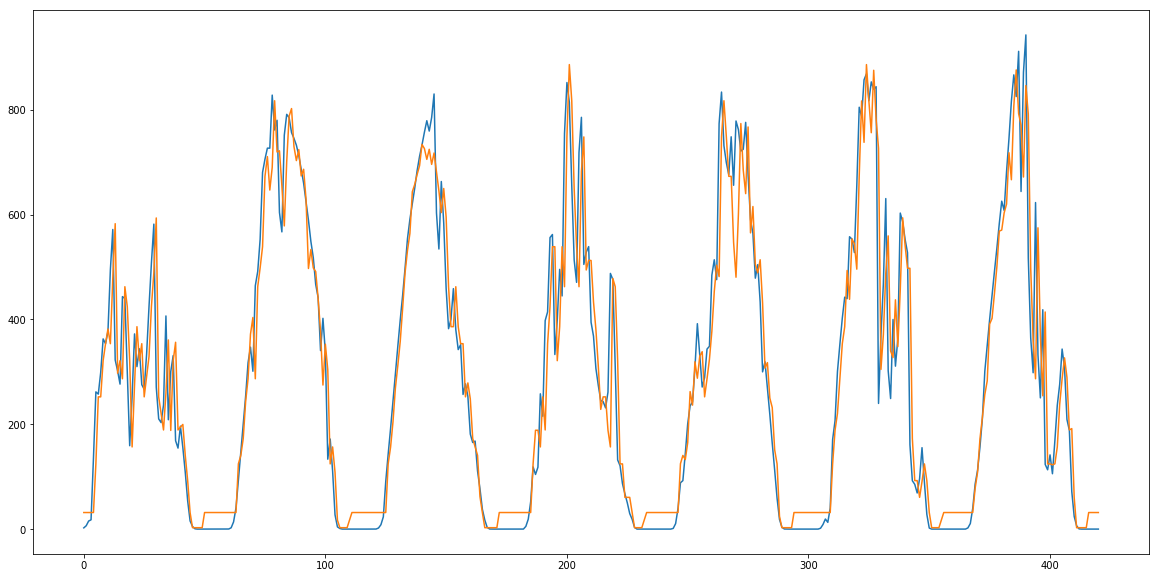

In [366]:
y_obs = validation_df[col].values
y_est = forecast_hofts_df[col].values

#_nrmse = normalized_rmse(y_obs[(_order-1):], y_est)
_nrmse = normalized_rmse(y_obs[_order:], y_est[:-1])
print("nRMSE: ", _nrmse, "\n")
plt.figure(figsize=(20,10))
plt.plot( y_obs[_order:])
plt.plot(y_est[:-1])

In [38]:

_nrmse = normalized_rmse(y_obs[(_order - 1):], y_est)
print("nRMSE: ", _nrmse, "\n")

nRMSE:  7.64644248447 



# Simple HOFTS

In [243]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models import hofts
from pyFTS.common import Transformations
tdiff = Transformations.Differential(1)

In [273]:
def hofts_forecast(_order, npartitions, col, train, validation):
    
    fuzzy_sets = Grid.GridPartitioner(data=train[col].values, npart=npartitions)
    model_simple_hofts = hofts.HighOrderFTS("FTS", partitioner=fuzzy_sets)
    
    #model_simple_hofts.append_transformation(Transformations.Differential(1))
    model_simple_hofts.fit(train[col].values, order=_order)
    
    return model_simple_hofts.predict(validation[col].values)

In [288]:
_order = 6
npartitions = 70
col = 'AP_1'


norm_residual_forecast = hofts_forecast(_order, npartitions, col, train_residual_df, validation_residual_df)
norm_clean_forecast = hofts_forecast(_order, npartitions, col, train_clean_df, validation_clean_df)

residual_forecast = denormalize(norm_residual_forecast, residual_sample_df[col].min(), residual_sample_df[col].max())
clean_forecast = denormalize(norm_clean_forecast, clean_sample_df[col].min(), clean_sample_df[col].max())

forecast = [r + c for r, c in zip(residual_forecast,clean_forecast)]

In [277]:
#forecast = hofts_forecast(_order, npartitions, col, train_df, validation_df)

In [289]:
y_est = forecast
y_obs = validation_df['AP_1'].values

#_nrmse = normalized_rmse(y_obs[(_order-1):], y_est)
_nrmse = normalized_rmse(y_obs[_order:], y_est[:-1])
print("nRMSE: ", _nrmse, "\n")

nRMSE:  31.2211880876 



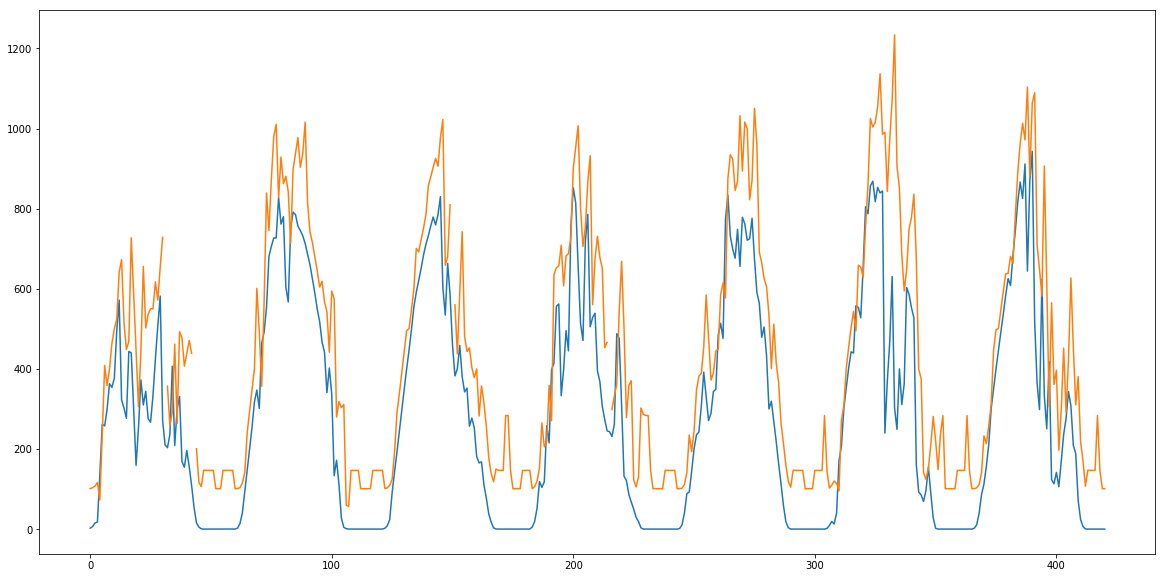

In [254]:
plt.figure(figsize=(20,10))
plt.plot( y_obs[_order:])
plt.plot(y_est[:-1])

#plt.plot( y_obs[_order-1:])
#plt.plot(y_est)

In [139]:
len(y_est)

422

# ANFIS

In [83]:
!pip install -U scikit-fuzzy
!pip install anfis

    100% |████████████████████████████████| 993kB 5.5MB/s 
Requirement not upgraded as not directly required: networkx>=1.9.0 in /Users/cseveriano/anaconda3/lib/python3.6/site-packages (from scikit-fuzzy) (2.0)
Requirement not upgraded as not directly required: decorator>=4.1.0 in /Users/cseveriano/anaconda3/lib/python3.6/site-packages (from networkx>=1.9.0->scikit-fuzzy) (4.2.1)
  Running setup.py bdist_wheel for scikit-fuzzy ... done
  Stored in directory: /Users/cseveriano/Library/Caches/pip/wheels/d3/9a/97/5a2dda0bb9d165b68c35a9ee9f5779b0665b96dddb98773205
Successfully built scikit-fuzzy
tensorflow-tensorboard 0.4.0rc3 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
tensorflow-tensorboard 0.4.0rc3 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.
  Running setup.py bdist_wheel for anfis ... done
  Stored in directory: /Users/cseveriano/Library/Caches/pip/wheels/68/60/6e/0266ec778599bf8e76ec5969800fe6fcccdb0

In [103]:
import sys
sys.path.append("/Users/cseveriano/anaconda3/lib/python3.6/site-packages/anfis")
sys.path.append("/Users/cseveriano/anaconda3/lib/python3.6/site-packages/anfis/membership")

In [108]:
import anfis
import membership #import membershipfunction, mfDerivs

In [100]:
_order = 6
col = 'AP_1'

train[col]

X = ts[:,0:2]
Y = ts[:,2]

mf = [[['gaussmf',{'mean':-11.,'sigma':5.}],['gaussmf',{'mean':-8.,'sigma':5.}],['gaussmf',{'mean':-14.,'sigma':20.}],['gaussmf',{'mean':-7.,'sigma':7.}]],
            [['gaussmf',{'mean':-10.,'sigma':20.}],['gaussmf',{'mean':-20.,'sigma':11.}],['gaussmf',{'mean':-9.,'sigma':30.}],['gaussmf',{'mean':-10.5,'sigma':5.}]]]


mfc = membership.membershipfunction.MemFuncs(mf)
anf = anfis.ANFIS(X, Y, mfc)
anf.trainHybridJangOffLine(epochs=10)
print round(anf.consequents[-1][0],6)
print round(anf.consequents[-2][0],6)
print round(anf.fittedValues[9][0],6)
if round(anf.consequents[-1][0],6) == -5.275538 and round(anf.consequents[-2][0],6) == -1.990703 and round(anf.fittedValues[9][0],6) == 0.002249:
	print 'test is good'
anf.plotErrors()
anf.plotResults()

ModuleNotFoundError: No module named 'membership'

In [116]:
col

'AP_1'

In [127]:
_order = 6
col = 'AP_1'

X_train_residual,Y_train_residual = reshape_data_matrix(train_residual_df[col].values, _order)
X_train_clean,Y_train_clean = reshape_data_matrix(train_clean_df[col].values, _order)

[0.51996060275365452,
 0.53474148070842442,
 0.53441235042350099,
 0.55724045196144767,
 0.50960622450805315,
 0.51871660702502131,
 0.54373253038054759,
 0.50099431145488715,
 0.43090153168722928,
 0.40755881014755557,
 0.46077068911624519,
 0.44486330510859906,
 0.50175295301951328,
 0.59597449814194059,
 0.68539018017517617,
 0.65068984919510042,
 0.53410879944178358,
 0.58715057642909219,
 0.49937398181771581,
 0.31129031704900789,
 0.12580127795105794,
 0.64051277330001566,
 1.0,
 0.32046943129383965,
 0.0,
 0.53219806671882186,
 0.74021312657414018,
 0.69037771640286716,
 0.5717284296838101,
 0.55858155758900541,
 0.58487121020201172,
 0.34882711659676946,
 0.37884382018466828,
 0.5237578148209433,
 0.53666828326575511,
 0.55896746070460435,
 0.53366708092836723,
 0.53594352252954613,
 0.51049253840160358,
 0.51808662284021489,
 0.46201427564378822,
 0.48448080576766861,
 0.52459236209763738,
 0.51488338624037466,
 0.48510161139554603,
 0.49609089761651209,
 0.5086168198148826,
 

In [122]:
def reshape_data_matrix(data, order):
    l = len(data)
    x = []
    y = []
    for k in np.arange(order, l):
        x.append(data[k - order: k])
        y.append(data[k])
    return x,y

In [129]:
l = 10
[i for i in np.arange(6, 10)]

[6, 7, 8, 9]

# Persistence

In [136]:
def persistence_forecast(data, data_clean, order):
    l = len(data)
    d = list(data)
    dc = list(data_clean)
    fcst = []
    for k in np.arange(order, l):
        irr = d[k-1]
        irr_clean = dc[k-1]
        irr_clean_nxt = dc[k]
        
        irr_nxt = (irr/irr_clean) * irr_clean_nxt
        fcst.append(irr_nxt)
    return fcst
        
    

In [135]:
list(validation_df[col])

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.12281186888888893,
 2.3383238866666614,
 6.4128811444444604,
 15.360379699999996,
 17.659238888888872,
 135.55972388888875,
 261.75385222222246,
 257.572222222221,
 299.01212555555577,
 362.8133188888881,
 353.69731777777827,
 377.09894555555525,
 494.59704444444304,
 571.5822011111102,
 322.59903333333415,
 301.764746666667,
 276.57910111111113,
 443.48817444444455,
 439.9602355555554,
 299.5859955555561,
 159.07562111111181,
 253.3398288888888,
 372.35716222222266,
 309.96910777777737,
 343.9635644444443,
 275.5323544444438,
 266.6442966666665,
 333.76271222222255,
 425.07138777777857,
 508.1486344444451,
 581.7999866666663,
 270.6800344444448,
 210.24401888888823,
 203.16454444444423,
 236.745773333333,
 406.61566888888933,
 208.62736522222173,
 300.67652866666657,
 330.9437568888885,
 168.6035475555545,
 154.51361877777794,
 196.42297055555508,
 155.53447433333318,
 108.47815277777792,
 53.88497644444454,
 15.599304666666667,
 5.084102522222169,
 0.

In [137]:


fc = persistence_forecast(validation_df[col], validation_clean_df[col], _order)

In [167]:
_nrmse = normalized_rmse(y_obs[(_order):], fc)
print("nRMSE: ", _nrmse, "\n")

nRMSE:  27.5947054867 



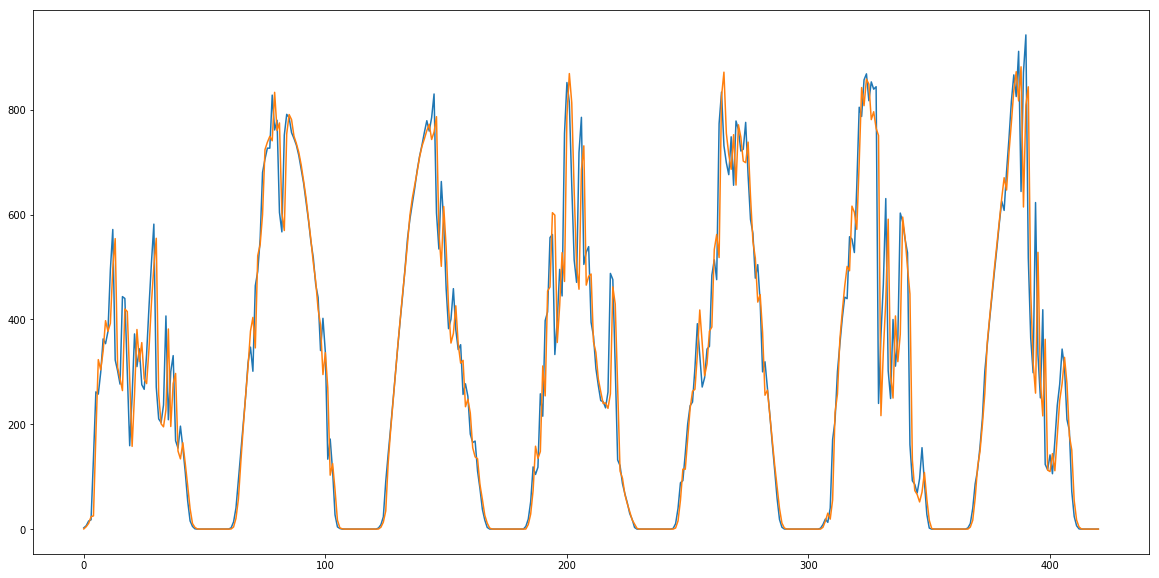

In [192]:
plt.figure(figsize=(20,10))
plt.plot( y_obs[_order:])
plt.plot(fc)


# High Order NonStationary FTS

In [202]:
from pyFTS.models.nonstationary import honsfts

In [203]:
def honsfts_forecast(_order, npartitions, col, train, validation):
    
    fuzzy_sets = Grid.GridPartitioner(data=train[col], npart=npartitions)
    model_honsfts = honsfts.HighOrderNonStationaryFTS("HONSFTS", partitioner=fuzzy_sets)
 #   model_simple_hofts.append_transformation(Transformations.Differential(1))
    model_honsfts.fit(train[col], order=_order)
    
    return model_honsfts.predict(validation[col])

In [296]:
_order = 8
npartitions = 50
col = 'AP_1'

norm_residual_forecast = honsfts_forecast(_order, npartitions, col, train_residual_df, validation_residual_df)
norm_clean_forecast = honsfts_forecast(_order, npartitions, col, train_clean_df, validation_clean_df)

In [297]:
residual_forecast = denormalize(norm_residual_forecast, residual_sample_df[col].min(), residual_sample_df[col].max())
clean_forecast = denormalize(norm_clean_forecast, clean_sample_df[col].min(), clean_sample_df[col].max())

forecast = [r + c for r, c in zip(residual_forecast,clean_forecast)]

nRMSE:  7.96498477321 



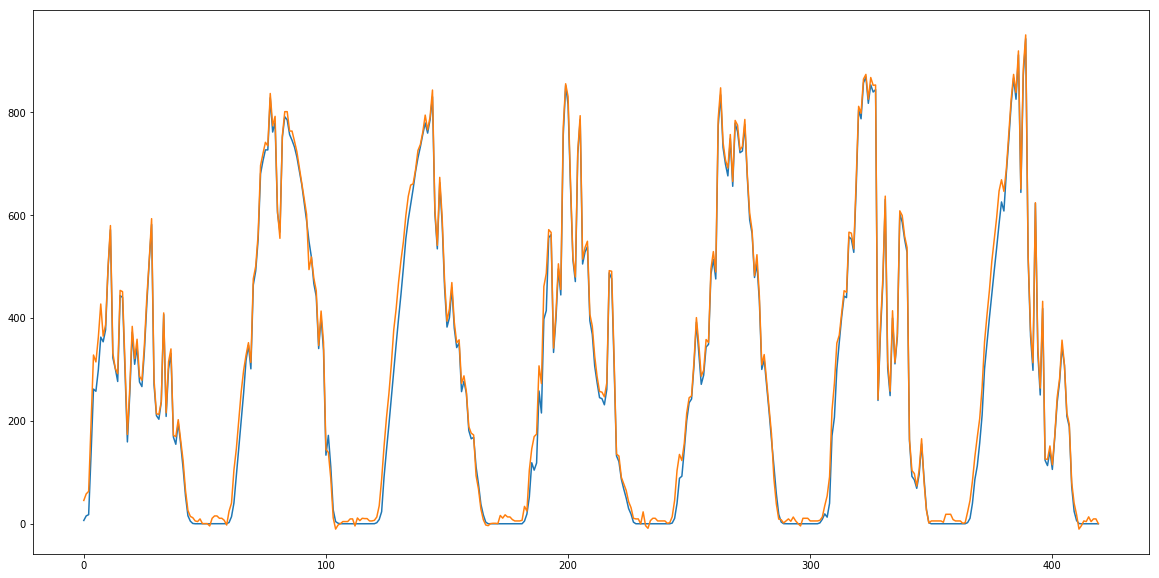

In [301]:
y_est = forecast
y_obs = validation_df['AP_1'].values

#_nrmse = normalized_rmse(y_obs[(_order-1):], y_est)
_nrmse = normalized_rmse(y_obs[_order:], y_est[:-1])
print("nRMSE: ", _nrmse, "\n")
plt.figure(figsize=(20,10))
plt.plot( y_obs[_order:])
plt.plot(y_est[:-1])

# Multivariate

In [308]:
def add_date(df):
    df_mv = df.copy()
    df_mv['date'] = df.index
    return df_mv

In [309]:
train_mv = add_date(train_df)
train_residual_mv = add_date(train_residual_df)
train_clean_mv = add_date(train_clean_df)

validation_mv = add_date(validation_df)
validation_residual_mv = add_date(validation_residual_df)
validation_clean_mv = add_date(validation_clean_df)

In [326]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime

#fig, axes = plt.subplots(nrows=2, ncols=1,figsize=[15,10])

sp = {'seasonality': DateTime.minute_of_day}

vhour = variable.Variable("Hour", data_label="date", partitioner=seasonal.TimeGridPartitioner, npart=24, 
                          data=train_mv, partitioner_specific=sp)

vavg = variable.Variable("Irradiance", data_label=col, partitioner=Grid.GridPartitioner, npart=50, 
                         data=train_mv) 
#vhour.partitioner.plot(axes[1])

#plt.tight_layout()


In [327]:
from pyFTS.models.multivariate import common, variable, mvfts

model1 = mvfts.MVFTS("")

model1.append_variable(vhour)

model1.append_variable(vavg)

model1.target_variable = vavg

model1.fit(train_mv)

In [328]:
forecast = model1.predict(validation_mv)

nRMSE:  29.3380627872 



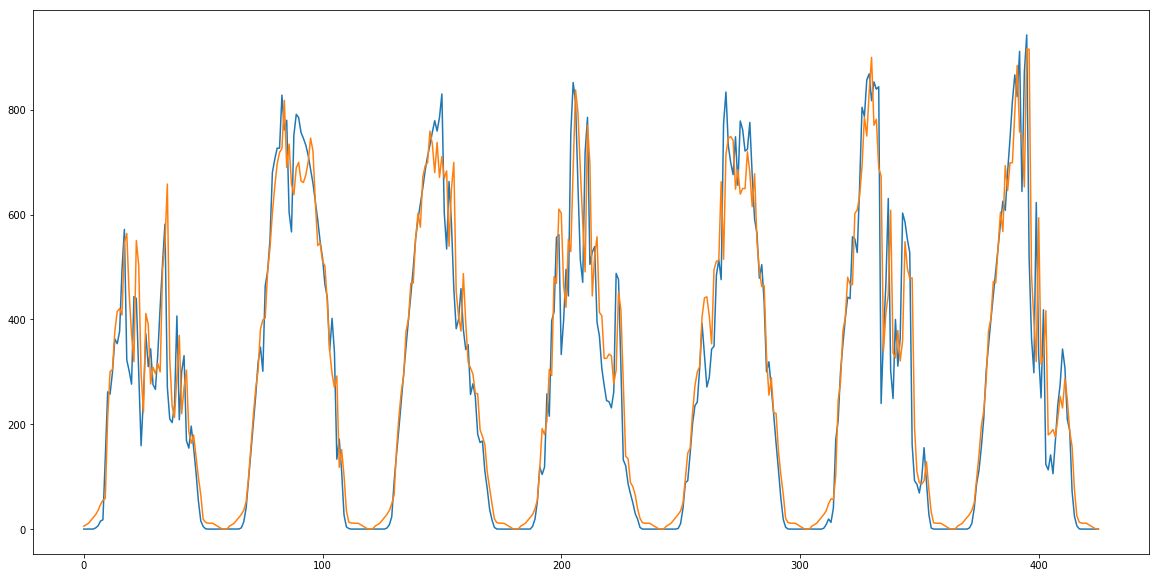

In [329]:
y_est = forecast
y_obs = validation_df['AP_1'].values

#_nrmse = normalized_rmse(y_obs[(_order-1):], y_est)
_nrmse = normalized_rmse(y_obs[1:], y_est[:-1])
print("nRMSE: ", _nrmse, "\n")
plt.figure(figsize=(20,10))
plt.plot( y_obs[1:])
plt.plot(y_est[:-1])

# SARIMA

In [334]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [338]:
# Initial approximation of parameters
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 2)
Ps = range(0, 2)
Ds = range(0, 2)
Qs = range(0, 2)
D=1
d=1
parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)

print("Num combinations: ", len(parameters_list))
# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    print(" Testing combination: ", param)
    try:
        model = SARIMAX(train_df[col].values, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], 96)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Num combinations:  64
 Testing combination:  (0, 0, 0, 0, 0, 0)
bad parameter combination: (0, 0, 0, 0, 0, 0)
 Testing combination:  (0, 0, 0, 0, 0, 1)
 Testing combination:  (0, 0, 0, 0, 1, 0)
bad parameter combination: (0, 0, 0, 0, 1, 0)
 Testing combination:  (0, 0, 0, 0, 1, 1)
 Testing combination:  (0, 0, 0, 1, 0, 0)
 Testing combination:  (0, 0, 0, 1, 0, 1)
 Testing combination:  (0, 0, 0, 1, 1, 0)
 Testing combination:  (0, 0, 0, 1, 1, 1)


KeyboardInterrupt: 

In [340]:
model = SARIMAX(train_df[col].values, order=(3, 1, 1), seasonal_order=(1, 1, 1, 24)).fit()


In [341]:
training_mod = SARIMAX(train_df[col].values, order=(6, 1, 1), seasonal_order=(1, 1, 1, 96))
training_res = training_mod.fit()

whole_data = train_df.append(validation_df)
test_data = validation_df

mod = SARIMAX(whole_data[col].values, order=(6, 1, 1), seasonal_order=(1, 1, 1, 96))
res = mod.filter(training_res.params)

insample = res.predict()
T = len(test_data)

In [347]:
wlen = len(whole_data)
tlen = len(test_data)

forecast = insample[wlen-tlen:]

nRMSE:  33.4852857738 



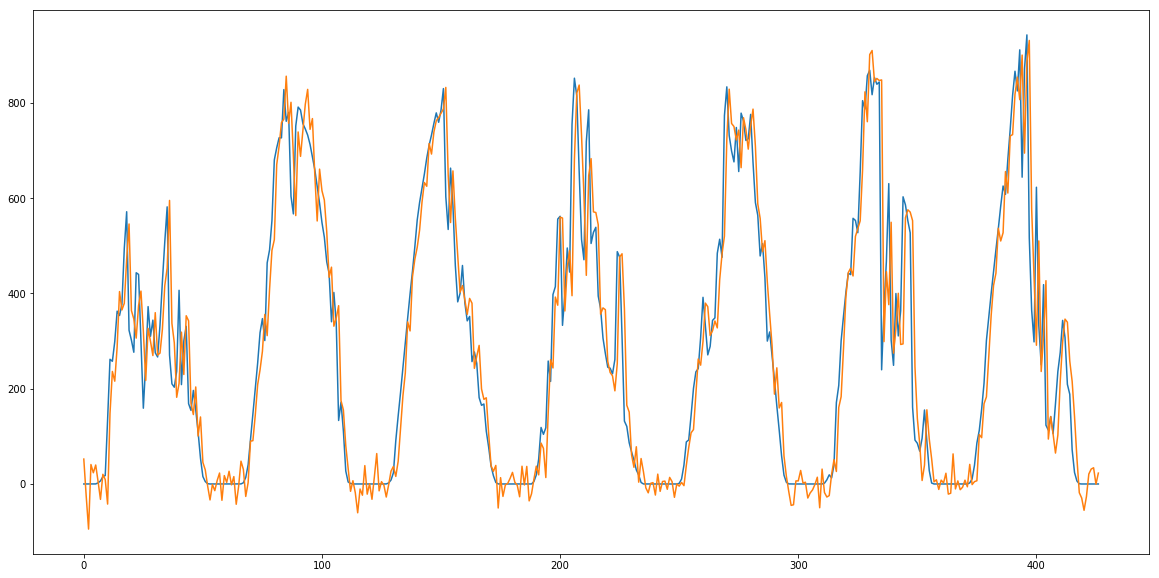

In [353]:
y_est = forecast
y_obs = validation_df['AP_1'].values

_nrmse = normalized_rmse(y_obs, y_est)
#_nrmse = normalized_rmse(y_obs[1:], y_est[:-1])
print("nRMSE: ", _nrmse, "\n")
plt.figure(figsize=(20,10))
plt.plot( y_obs)
plt.plot(y_est)